In [4]:
import matplotlib.pyplot as plt
import numpy as np
import math
from mpl_toolkits import mplot3d

In [5]:
# Advised constants
alpha = 0.007 #gilbert damping constant
mu_0 = 4*math.pi*(10**(-7)) #(Tm/A)
gamma = 1.76*(10**11) #(rad/sT) gyromagnetic ratio of electron
M_s = 850*10**(3) #(A/m) Saturation magnetization of nanomagnet
I_s = 0.4644 #(A) applied spin current
delta = 42 #thermal stability factor
temp = 300 #(K) temperature
ht = 6.62607015*(10**(-34)) # (J Hz^-1) planck constant from nist
q_e = 1.602176634*(10**(-19)) # (C) elementary charge of electron from nist
k_B = 1.380649*(10**(-23)) # (JK^-1) Boltzmann constant from nist
 

# MTJ dimensions
W = 40 #(nm)
L = 120 #(nm)
t_fl = 1.5 #(nm)
A = (math.pi/4)*L*W # cross sectional area of MTJ
V = A*t_fl

J_mtj = I_s/A # surface current for mtj

H_k = 2*delta*k_B*temp/(V*mu_0*M_s)
demag_const = np.array([-0.066*M_s, -0.911*M_s, -0.022*M_s])
m_p = np.array([0,0,1])

In [6]:
# differential equation dm/dt for LLGS (based on debasis' note)" 
def llgs(t, m, H_eff):
    beta = (gamma*ht*J_mtj)/(2*q_e*M_s*t_fl) 
    return -(gamma*mu_0)/(1+alpha**2) * np.cross(m, H_eff) \
    - alpha*(gamma*mu_0)/(1+alpha**2) * np.cross(m, np.cross(m,H_eff)) \
    - beta/(1+alpha**2) * np.cross(m, np.cross(m, m_p)) \
    + alpha*beta/(1+alpha**2) * np.cross(m,m_p)

def llgsRK(x_n, y_n, x, h, H_eff): 
    y = y_n 
    n = int((x - x_n)/h) 
    # Iterate for n number of iterations 
    for i in range(1, n + 1): 
        "Apply Runge Kutta Formulas to find next value of y"
        k1 = h * llgs(x_n, y, H_eff) 
        k2 = h * llgs(x_n + 0.5*h, y + 0.5*k1, H_eff) 
        k3 = h * llgs(x_n + 0.5*h, y + 0.5*k2, H_eff) 
        k4 = h * llgs(x_n + h, y + k3, H_eff) 
        # Update next value of y 
        y = y + (1.0 / 6.0)*(k1 + 2*k2 + 2*k3 + k4) 
        # Update next value of x 
        x_n = x_n + h 
    return y

# calculate y value of x series
def calcMSeries(t_axis, h, t_0, m_0):
    # RK4 solution
    m_rk4 = []
    m_prev = m_0
    t_prev = t_0
    
    H_eff = np.add([0,0,H_k*m_0[2]], np.multiply(demag_const, m_0))    
    for t in t_axis:
        new_m = llgsRK(t_prev, m_prev, t, h, H_eff)
        m_rk4.append(new_m)
        m_prev = new_m
        t_prev = t
        H_eff = np.add([0,0,H_k*new_m[2]], np.multiply(demag_const, new_m) )
        
    # change all elements to list
    for i in range(1,len(m_rk4)):
        m_rk4[i] = m_rk4[i].tolist()
    return m_rk4

# Plots 
def plotM(t_axis, m_list):
    # separate mx my mz
    mx = [item[0] for item in m_list]
    my = [item[1] for item in m_list]
    mz = [item[2] for item in m_list]

    # plot result
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)

    plt.plot(t_axis, mx, '.r-', label='mx')
    plt.plot(t_axis, my, '.g-', label='my')
    plt.plot(t_axis, mz, '.b-', label='mz')

    plt.title("Using Simulation parameter from paper")
    plt.xlabel("t/s")
    plt.ylabel("mx,my,mz")
    plt.legend(loc='upper right')
    plt.grid()

    plt.show()


### Simulating full MTJ

In [10]:
t_range = 2*10**(-8)
t_0 = 0
step_amount = 2001
t_axis = np.linspace(t_0,t_range,step_amount)

h = t_range/step_amount
# m_0 = [0, 1/2, math.sqrt(1-(1/2)**2)]
m_0 = np.array([0,0,-0.99])

In [11]:
m_rk4 = calcMSeries(t_axis, h, t_0, m_0)

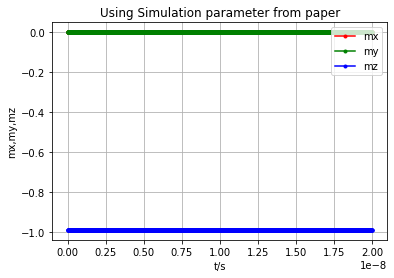

In [12]:
plotM(t_axis, m_rk4)